Reference: 
1. https://seaborn.pydata.org/tutorial/categorical.html


In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [55]:
%pylab inline
import numpy as np
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set(style="darkgrid", color_codes=True) #whitegrid 
from sklearn import metrics
from xgboost import XGBClassifier,plot_importance,DMatrix,cv, train
from sklearn.model_selection import train_test_split
import math
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
0.23.3


In [2]:
filename1 = "../Data_folder/04_Fraud/Fraud_Data.csv"
filename2 = "../Data_folder/04_Fraud/IpAddress_to_Country.csv"
fraud_data = pd.read_csv(filename1) #, encoding = "ISO-8859-1",na_values=['','None','NA'])
ip_data = pd.read_csv(filename2) #, encoding = "ISO-8859-1",na_values=['','None','NA'])

In [3]:
fraud_data.describe(include = 'all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-07-27 23:55:47,2015-07-17 23:22:55,NaN,KIPFSCNUGOLDP,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


In [4]:
ip_data.describe(include = 'all')

,lower_bound_ip_address,upper_bound_ip_address,country
count,1.388460e+05,1.388460e+05,138846
unique,NaN,NaN,235
top,NaN,NaN,United States
freq,NaN,NaN,46868
mean,2.724532e+09,2.724557e+09,NaN
std,8.975215e+08,8.974979e+08,NaN
min,1.677722e+07,1.677747e+07,NaN
25%,1.919930e+09,1.920008e+09,NaN
50%,3.230887e+09,3.230888e+09,NaN
75%,3.350465e+09,3.350466e+09,NaN


In [10]:
fraud_sample = fraud_data #.head(5000)

In [11]:
# numpy broadcasting

# %%time
# a = fraud_sample.ip_address.values
# bh = ip_data.upper_bound_ip_address.values
# bl = ip_data.lower_bound_ip_address.values

# i, j = np.where((a[:, None] >= bl) & (a[:, None] <= bh))

CPU times: user 2min 51s, sys: 1min 44s, total: 4min 36s
Wall time: 5min 15s


In [13]:
variable_names = list(fraud_sample.columns.values)

# merge1 = pd.DataFrame(
#     np.column_stack([fraud_sample.values[i], ip_data.country.values[j]]),
#     columns=variable_names+["country"]
# )

merge = pd.DataFrame(
    np.column_stack([fraud_sample.values[i], ip_data.country.values[j]]),
    columns=variable_names+["country"]
).append(
    fraud_sample[~np.in1d(np.arange(len(fraud_sample)), np.unique(i))]
    ,ignore_index=True, sort=False
)

In [20]:
merge.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.32758e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.50311e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.15583e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.80932e+09,0,Canada


In [15]:
merge.shape

(151112, 12)

In [106]:
merge.to_csv('../Data_folder/04_Fraud/Farud_merge.csv', index = False)

## Next time starts from here:

In [3]:
mergefile = "../Data_folder/04_Fraud/Farud_merge.csv"
data = pd.read_csv(mergefile)

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           129146 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [134]:
# check missing value
data.isnull().sum()

user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           21966
dtype: int64

In [5]:
# convert time to correct datatype
data['signup_time'] =  pd.to_datetime(data['signup_time'], format='%Y-%m-%d %H:%M:%S')
data['purchase_time'] =  pd.to_datetime(data['purchase_time'], format='%Y-%m-%d %H:%M:%S')



## Creat new variables 
# Calculate duration between purchase and signup date
data['duration'] = (data['purchase_time'] - data['signup_time']).astype('timedelta64[s]') # D: day; h: hour

# hour of a day
data['signup_time_hour'] = data['signup_time'].dt.hour
data['purchase_time_hour'] = data['purchase_time'].dt.hour
# day of the week
data['signup_time_wd'] = data['signup_time'].dt.weekday
data['purchase_time_wd'] = data['purchase_time'].dt.weekday
# week of the yr
data['signup_time_wy'] = data['signup_time'].dt.week
data['purchase_time_wy'] = data['purchase_time'].dt.week

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 19 columns):
user_id               151112 non-null int64
signup_time           151112 non-null datetime64[ns]
purchase_time         151112 non-null datetime64[ns]
purchase_value        151112 non-null int64
device_id             151112 non-null object
source                151112 non-null object
browser               151112 non-null object
sex                   151112 non-null object
age                   151112 non-null int64
ip_address            151112 non-null float64
class                 151112 non-null int64
country               129146 non-null object
duration              151112 non-null float64
signup_time_hour      151112 non-null int64
purchase_time_hour    151112 non-null int64
signup_time_wd        151112 non-null int64
purchase_time_wd      151112 non-null int64
signup_time_wy        151112 non-null int64
purchase_time_wy      151112 non-null int64
dtypes: datetime64[ns](2),

In [12]:
def get_column_types(dataframe):
    numeric_cols = dataframe.select_dtypes([np.number,numpy.float64]).columns.values
    cat_cols = dataframe.select_dtypes([np.object]).columns.values
    date_cols = dataframe.select_dtypes([np.datetime64]).columns.values
    print("In total there's %d columns" % dataframe.shape[1] )
    print('These %d columns are numeric: %s'% (len(numeric_cols),numeric_cols))
    print('These %d columns are catgorical: %s'% (len(cat_cols),cat_cols))
    print('These %d columns are catgorical: %s'% (len(date_cols),date_cols))
    return numeric_cols,cat_cols,date_cols

In [7]:
num_cols,cat_cols,date_cols = get_column_types(data) 

In total there's 19 columns
These 12 columns are numeric: ['user_id' 'purchase_value' 'age' 'ip_address' 'class' 'duration'
 'signup_time_hour' 'purchase_time_hour' 'signup_time_wd'
 'purchase_time_wd' 'signup_time_wy' 'purchase_time_wy']
These 5 columns are catgorical: ['device_id' 'source' 'browser' 'sex' 'country']
These 2 columns are catgorical: ['signup_time' 'purchase_time']


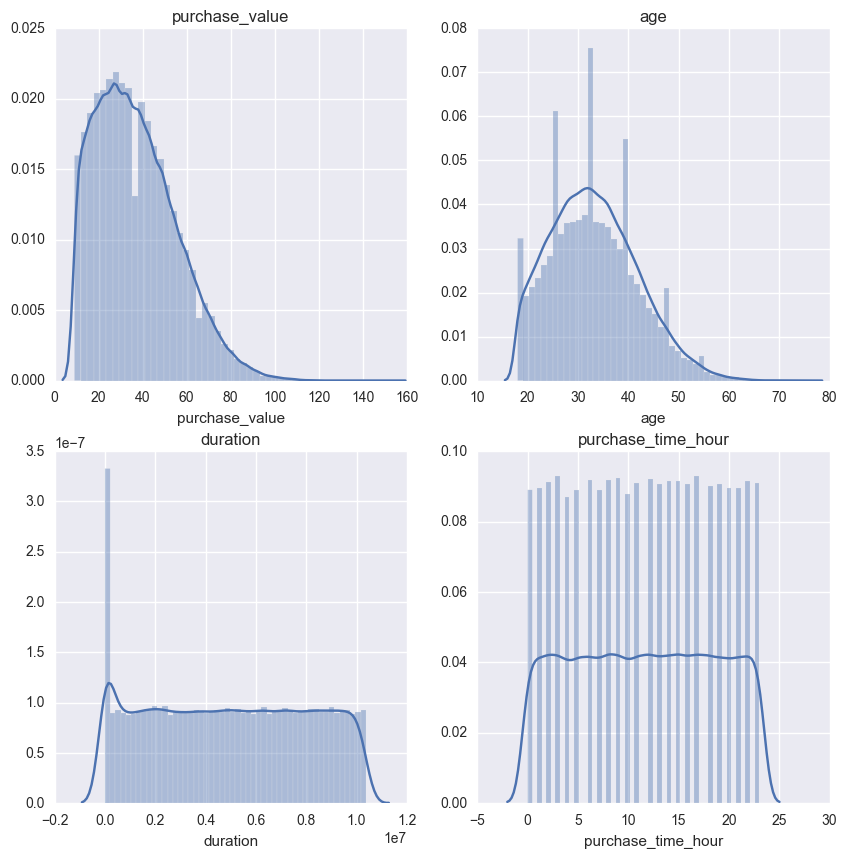

In [145]:
def plot_numeric_var(dataframe, numeric_cols, target_col):
    ncol = math.ceil(len(numeric_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(10,10))
    for idx, col_name in enumerate(numeric_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        sns.distplot(dataframe[col_name], ax=ax0)

        
plot_numeric_var(data,numeric_cols = ['purchase_value', 'age', 'duration','purchase_time_hour'], target_col = 'class' )

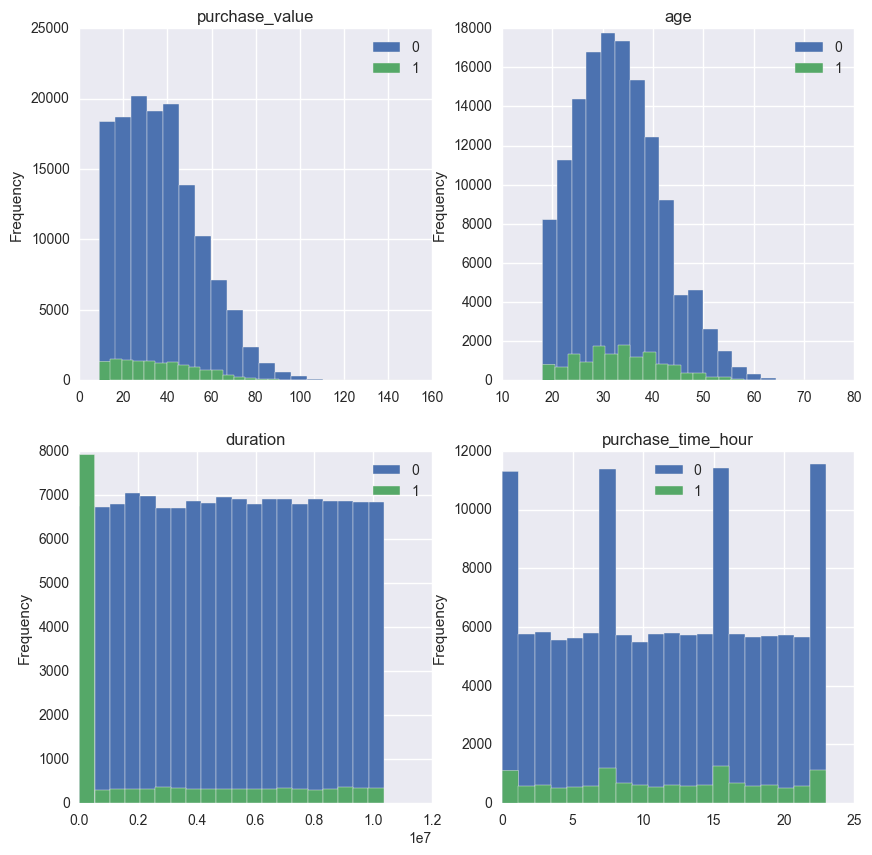

In [141]:
def plot_numeric_var(dataframe, numeric_cols, target_col):
    ncol = math.ceil(len(numeric_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(10,10))
    for idx, col_name in enumerate(numeric_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        dataframe.groupby(target_col)[col_name].plot(kind = 'hist',bins=20, ax=ax0, legend = True)

plot_numeric_var(data,numeric_cols = ['purchase_value', 'age', 'duration','purchase_time_hour'], target_col = 'class' )

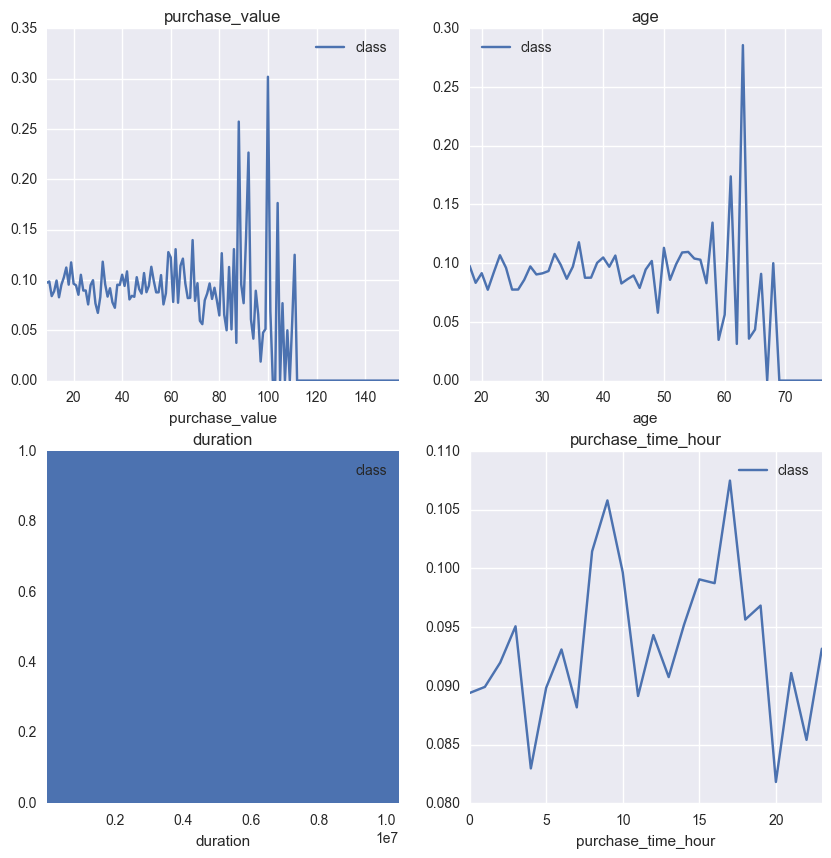

In [147]:
def plot_numeric_var(dataframe, numeric_cols, target_col):
    ncol = math.ceil(len(numeric_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(10,10))
    for idx, col_name in enumerate(numeric_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        dataframe.groupby(col_name)[target_col].mean().plot(ax=ax0, legend = True)
plot_numeric_var(data,numeric_cols = ['purchase_value', 'age', 'duration','purchase_time_hour'], target_col = 'class' )

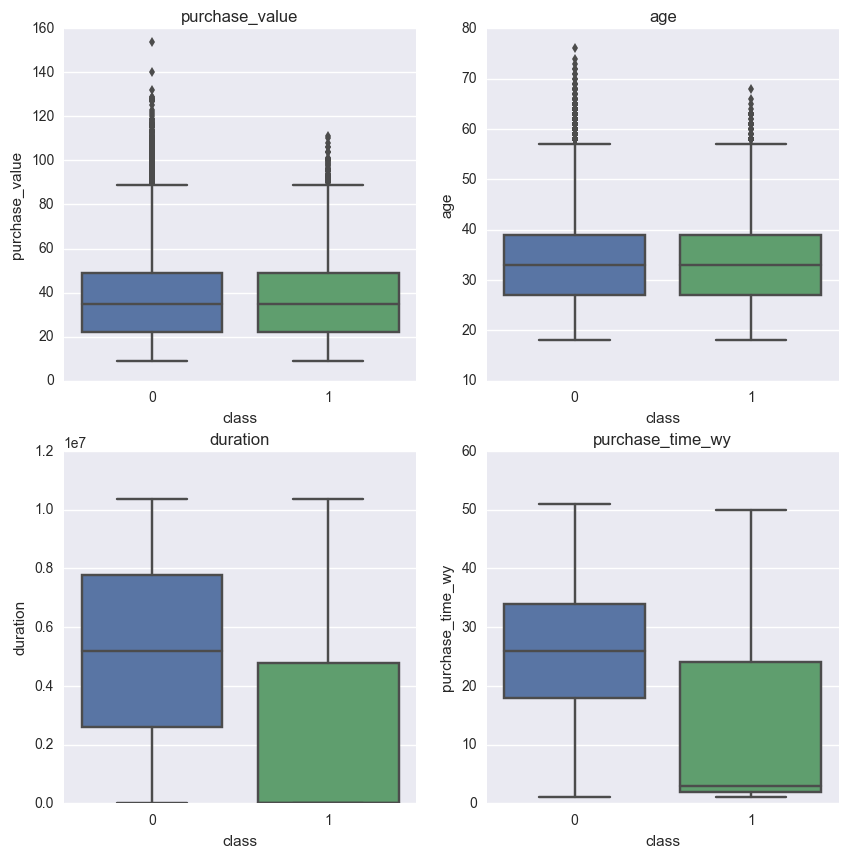

In [152]:
def plot_numeric_var(dataframe, numeric_cols, target_col):
    ncol = math.ceil(len(numeric_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(10,10))
    for idx, col_name in enumerate(numeric_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        sns.boxplot(x=target_col, y=col_name, data=dataframe, ax= ax0)

plot_numeric_var(data,numeric_cols = ['purchase_value', 'age', 'duration','purchase_time_wy'], target_col = 'class')

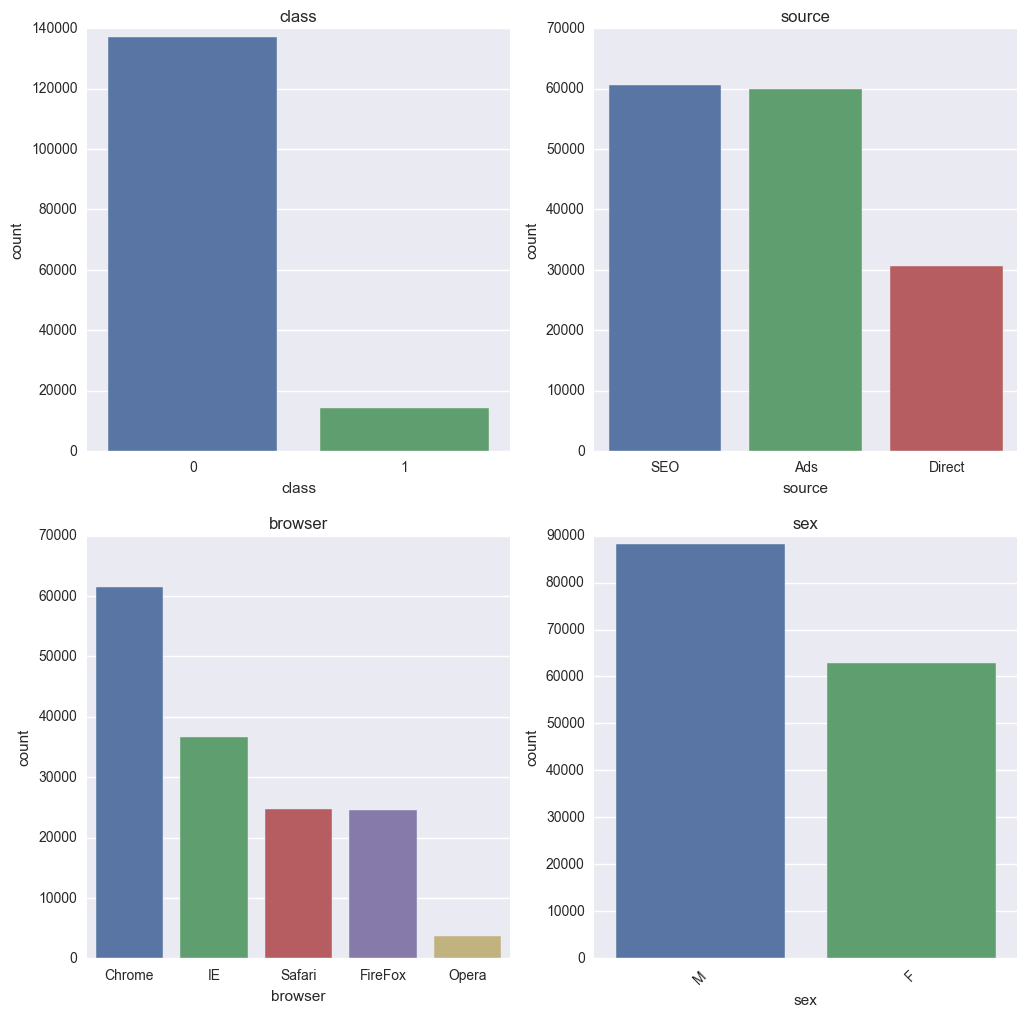

In [155]:
cat_cols = ['class','source', 'browser', 'sex']
target_col = 'class'
def plot_category_var(dataframe, cat_cols, target_col):
    ncol = math.ceil(len(cat_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(12,12))
    for idx, col_name in enumerate(cat_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        sns.countplot(x=col_name, data=dataframe, ax= ax0, orient = 'h'
                     ,order = dataframe[col_name].value_counts().index) # , hue=target_col
        plt.xticks(rotation=45)

#         dataframe[col_name].hist(bins=20, ax=ax0)
#         dataframe.groupby(target_col)[col_name].plot(kind = 'hist',bins=20, ax=ax0, legend = True)
#         dataframe.groupby(col_name)[target_col].mean().plot(ax=ax0, legend = True)
#         sns.boxplot(x=target_col, y=col_name, data=dataframe, ax= ax0)

plot_category_var(data, cat_cols = ['class','source', 'browser', 'sex'], target_col = 'class' )

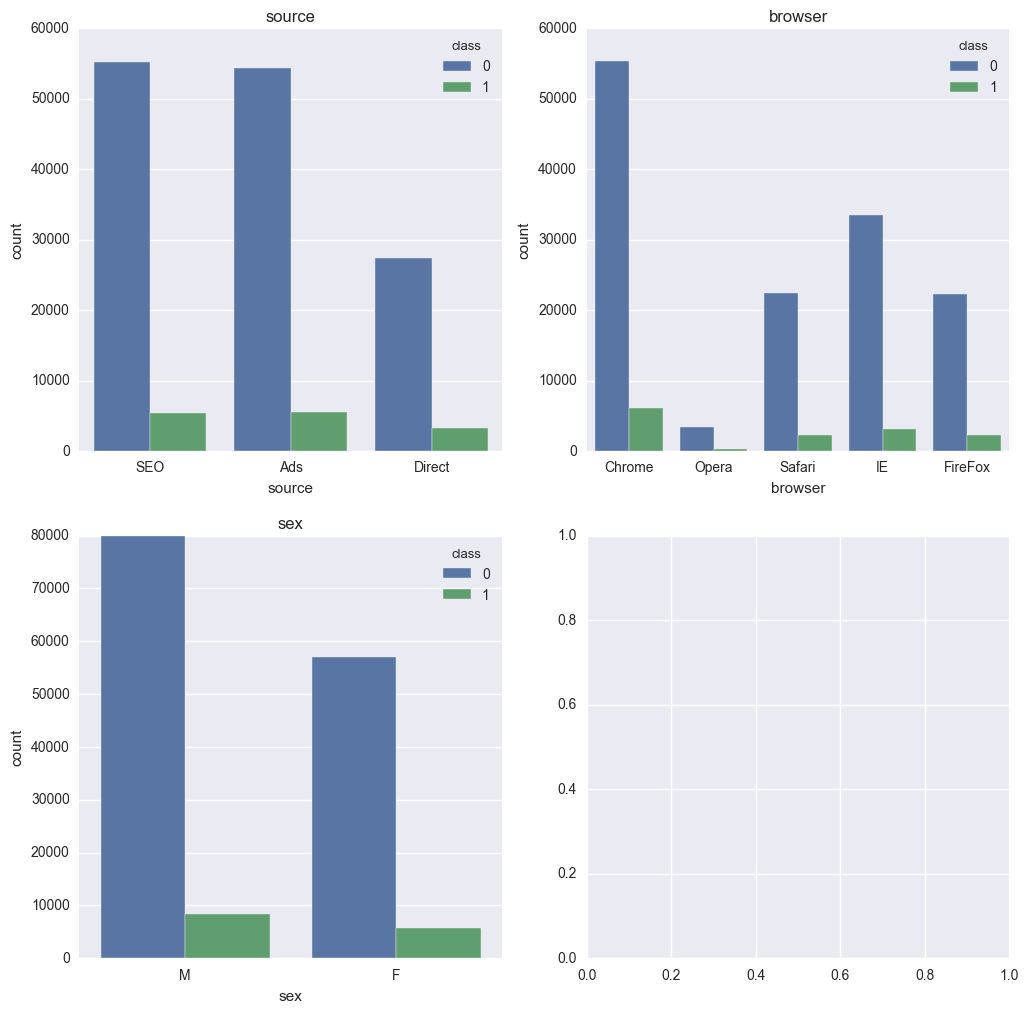

In [156]:
cat_cols = ['class','source', 'browser', 'sex']
target_col = 'class'
def plot_category_var(dataframe, cat_cols, target_col):
    ncol = math.ceil(len(cat_cols)/2)
    fig, axes= plt.subplots(ncol,2,figsize=(12,12))
    for idx, col_name in enumerate(cat_cols):
        ax0=axes[int(np.floor(idx/2)),idx%2]
        ax0.set_title(col_name)
        sns.countplot(x=col_name, hue=target_col, data=dataframe, ax = ax0)
#         plt.xticks(rotation=45)


plot_category_var(data, cat_cols = ['source', 'browser', 'sex'], target_col = 'class' )

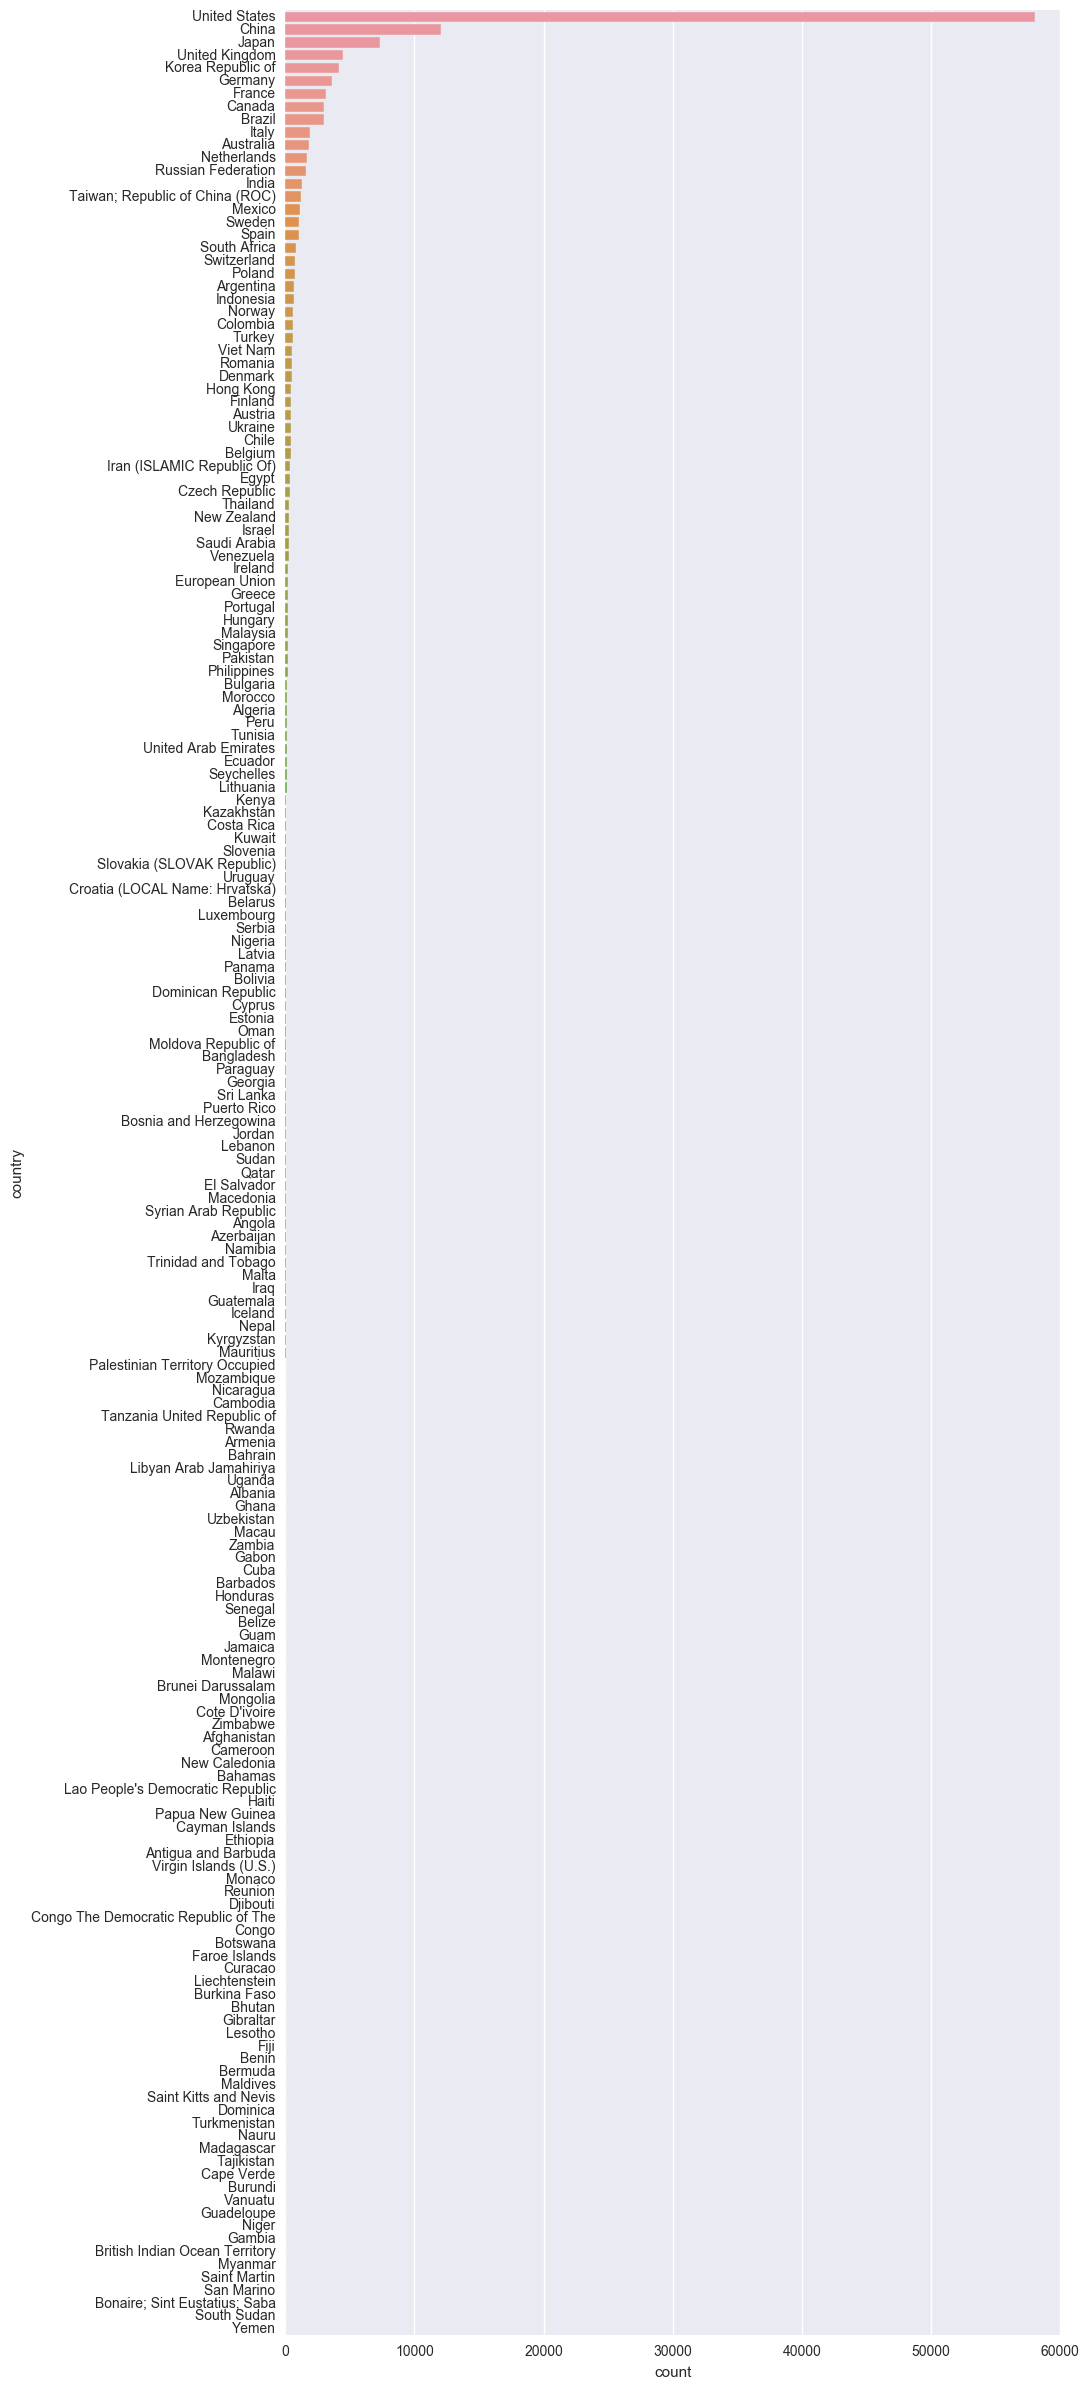

In [158]:
plt.subplots(figsize=(10, 30))
sns.countplot(y='country', data=data, orient = 'v'
                     ,order = data['country'].value_counts().index) 

## Country variable

In [72]:
# Check unique values in countries, see if there's any "USA", "America", "US" kind of duplicate
data['country'].unique()
# No duplicates, misspell needs to replace 

array(['Japan', 'United States', 'Canada', 'China', 'Brazil', 'India',
       'Argentina', 'United Kingdom', 'South Africa', 'Germany', 'Mexico',
       'Sweden', 'Korea Republic of', 'Peru', 'Portugal', 'Bangladesh',
       'France', 'Taiwan; Republic of China (ROC)', 'Russian Federation',
       'Belgium', 'Denmark', 'Netherlands', 'Iran (ISLAMIC Republic Of)',
       'Spain', 'Gabon', 'Saudi Arabia', 'Hong Kong', 'Georgia',
       'Syrian Arab Republic', 'Turkey', 'New Zealand', 'European Union',
       'Australia', 'Ukraine', 'Austria', 'Israel', 'Malaysia', 'Greece',
       'Italy', 'Norway', 'Poland', 'Venezuela', 'Thailand', 'Chile',
       'Morocco', 'Finland', 'Hungary', 'Indonesia', 'Colombia', 'Ecuador',
       'Lithuania', 'Switzerland', 'Viet Nam', 'Nigeria', 'Egypt',
       'Seychelles', 'Kazakhstan', 'Kenya', 'Moldova Republic of',
       'Trinidad and Tobago', 'Qatar', 'Bolivia', 'Bulgaria', 'Romania',
       'Croatia (LOCAL Name: Hrvatska)', 'Cyprus', 'Czech Republic',

In [162]:
data['country'].value_counts().head(10).reset_index()

,index,country
0,United States,58049
1,Unknown,21966
2,China,12038
3,Japan,7306
4,United Kingdom,4490
5,Korea Republic of,4162
6,Germany,3646
7,France,3161
8,Canada,2975
9,Brazil,2961


In [6]:
# Replace missing value
data['country'].fillna('Unknown', inplace=True)

# Find top 10 countries, everything else is "other" 
country10 = data['country'].value_counts().head(10)#.reset_index()
print(country10)
print(list(country10.index))
print(list(country10.values))
country10 = list(country10.index)
data.loc[~data['country'].isin(country10), 'country'] = 'Other'

United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: country, dtype: int64
['United States', 'Unknown', 'China', 'Japan', 'United Kingdom', 'Korea Republic of', 'Germany', 'France', 'Canada', 'Brazil']
[58049, 21966, 12038, 7306, 4490, 4162, 3646, 3161, 2975, 2961]


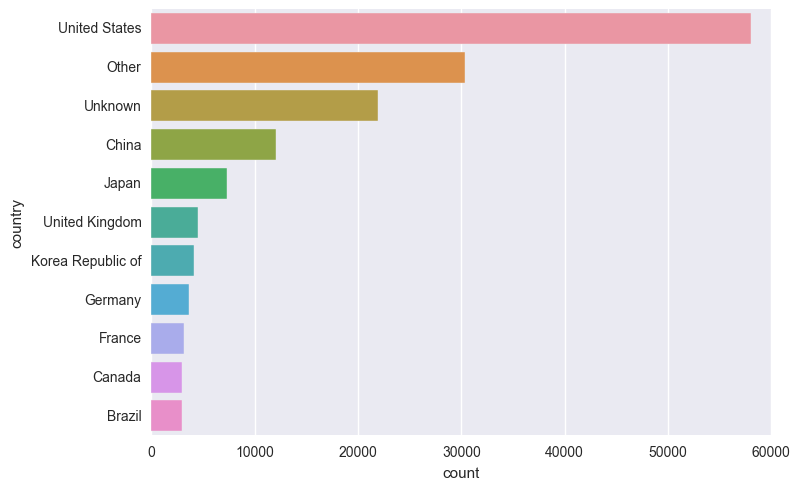

In [164]:
# plt.subplots(figsize=(10, ))
sns.countplot(y='country', data=data, orient = 'v'
                     ,order = data['country'].value_counts().index) 

In [7]:
ip_share_user = data.groupby('ip_address')['user_id'].count().reset_index().rename(columns={'user_id':'count_users_share_same_ip'})
ip_share_user.sort_values(by=['count_users_share_same_ip'], ascending=False).head()

,ip_address,count_users_share_same_ip
50543,1.502818e+09,20
19944,5.760609e+08,20
128962,3.874758e+09,20
68161,2.050964e+09,20
97533,2.937899e+09,19


In [8]:
device_share_user = data.groupby('device_id')['user_id'].count().reset_index().rename(columns={'user_id':'count_users_share_same_device'})
device_share_user.sort_values(by=['count_users_share_same_device'], ascending=False).head()

,device_id,count_users_share_same_device
54521,KIPFSCNUGOLDP,20
69916,NGQCKIADMZORL,20
14100,CQTUVBYIWWWBC,20
46203,ITUMJCKWEYNDD,20
24607,EQYVNEGOFLAWK,20


In [9]:
# Join addition info to base table

data = data.merge(right = ip_share_user, on='ip_address', how='left')
data = data.merge(right = device_share_user, on='device_id', how='left')

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country,duration,signup_time_hour,purchase_time_hour,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy,count_users_share_same_ip,count_users_share_same_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Japan,4506682.0,22,2,1,5,9,16,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,United States,17944.0,20,1,6,0,23,24,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,1.0,18,18,3,3,1,1,12,12
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,United States,4361461.0,7,18,1,2,30,37,1,1
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,...,Canada,4240931.0,6,8,3,3,21,28,1,1


## Prepare data model, Train/test split

In [13]:
numeric_cols,cat_cols, _  = get_column_types(data)

In total there's 21 columns
These 14 columns are numeric: ['user_id' 'purchase_value' 'age' 'ip_address' 'class' 'duration'
 'signup_time_hour' 'purchase_time_hour' 'signup_time_wd'
 'purchase_time_wd' 'signup_time_wy' 'purchase_time_wy'
 'count_users_share_same_ip' 'count_users_share_same_device']
These 5 columns are catgorical: ['device_id' 'source' 'browser' 'sex' 'country']
These 2 columns are catgorical: ['signup_time' 'purchase_time']


In [14]:
numeric_cols = ['purchase_value', 'age', 'duration', 'signup_time_hour', 'purchase_time_hour', 
                'signup_time_wd', 'purchase_time_wd', 'signup_time_wy', 'purchase_time_wy',
                'count_users_share_same_ip','count_users_share_same_device']
cat_cols = ['source', 'browser', 'sex', 'country']
y_var = 'class'
y = data[y_var]
# X = dataframe.drop('y', axis=1)
X = data[numeric_cols+cat_cols]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, prefix=cat_cols)

In [15]:
X.head()

,purchase_value,age,duration,signup_time_hour,purchase_time_hour,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy,count_users_share_same_ip,...,country_Canada,country_China,country_France,country_Germany,country_Japan,country_Korea Republic of,country_Other,country_United Kingdom,country_United States,country_Unknown
0,34,39,4506682.0,22,2,1,5,9,16,1,...,0,0,0,0,1,0,0,0,0,0
1,16,53,17944.0,20,1,6,0,23,24,1,...,0,0,0,0,0,0,0,0,1,0
2,15,53,1.0,18,18,3,3,1,1,12,...,0,0,0,0,0,0,0,0,1,0
3,39,45,4361461.0,7,18,1,2,30,37,1,...,0,0,0,0,0,0,0,0,1,0
4,42,18,4240931.0,6,8,3,3,21,28,1,...,1,0,0,0,0,0,0,0,0,0


In [16]:
# Feature Scaling - Standardization

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.30, random_state=11)
# std_scale = preprocessing.StandardScaler().fit(X_train[numeric_cols])
# X_train[numeric_cols] = std_scale.transform(X_train[numeric_cols])
# X_val[numeric_cols] = std_scale.transform(X_val[numeric_cols])

In [33]:
# cross validation to get model best model
def modelfit(alg,X,y,useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = DMatrix(X.values, label=y.values)
        cvresult = cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                      nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds
                     )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
#     plot_importance(gbm,importance_type ='gain' , max_num_features = 10)
    return alg

In [18]:
# Helper function to get AUC plot
def model_evaluation(y_test,y_pred,model='',plot=True):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    if plot:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.4f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(model+' Model - Plot ROC over Validation Dataset')
        plt.legend(loc="lower right")
        plt.show()
    else: 
        print("AUC Score (Validation): %f" % auc)


Model Report
Accuracy : 0.9566
AUC Score (Train): 0.846248
AUC Score (Validation): 0.846091


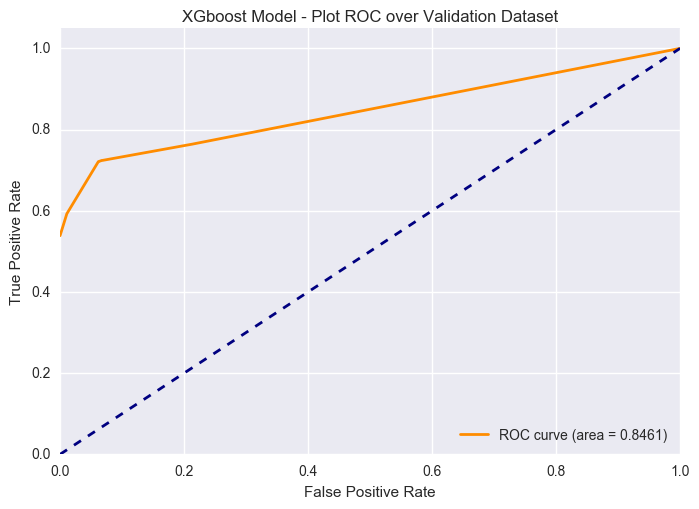

CPU times: user 14.2 s, sys: 739 ms, total: 14.9 s
Wall time: 15.4 s


In [34]:
%%time
gbm = XGBClassifier()
xgb1 = modelfit(gbm, X_train,y_train)
y_probabilities = xgb1.predict_proba(X_val)[:,1]
y_predictions = xgb1.predict(X_val)
model_evaluation(y_val,y_probabilities, 'XGboost', plot=False)
model_evaluation(y_val,y_probabilities, 'XGboost')

# gbm = gbm.fit(X_train, y_train)

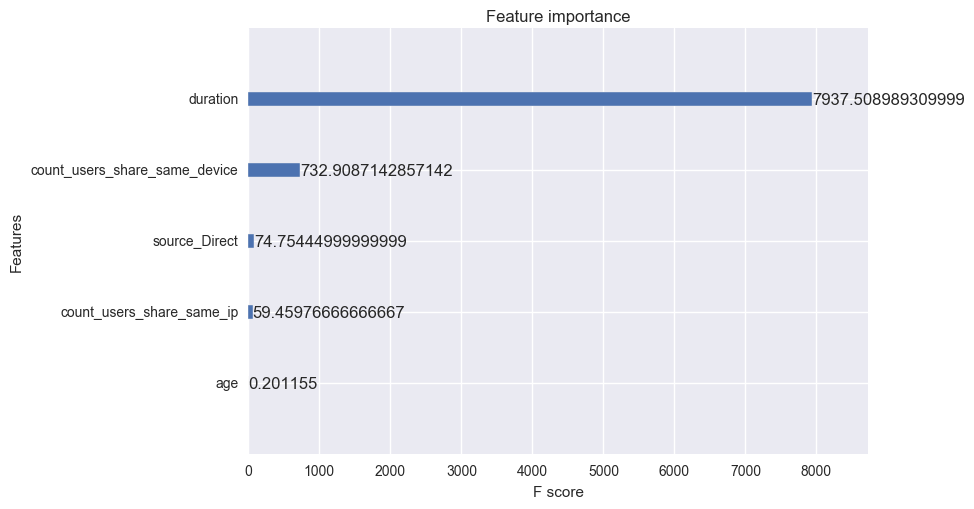

In [209]:
plot_importance(xgb1 , max_num_features = 20, importance_type = 'gain')
# feature importance https://xgboost.readthedocs.io/en/latest/python/python_api.html

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).  

**Understanding how ROC works is really important. So please review it if you are not familiar with it. In many practical ML applications, there is no reason to use the default 0.5 cut-off value.**    

In terms of getting insights, this is similar to the conversion rate challenge, so we won’t redo it. The most effective strategy is again:  

Look at random forest variable importance plot partial dependence plots of the most important variables and finally build a simple and small tree and look at the main splits.  

Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:  
1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)  
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.  
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.  

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).  

## Cost Sensitive Learning with XGBoost 


In ML, we usually assume the cost of predicting a FP is same as FN. But in certain cases, this is not true. Like to predict live/die of a patient or click through rate.  

In our case, the cost of falsely identify a fraud which is actually safe transaction may lead to blocking the transaction, thus the customer can't buy immediately, customer need to response a phone call to verify or they may cancel the tranaction completely. In general if we consider the margin of any product is 20%. The company is at risk of maximum losing the margin. In contrary, if we falsely predict an actual fraud. The company is at risk of losing 100% of the value. So here, we can see the cost of FP and FN is different.

We can assign a cost matrix that associate with:  


|               | True Safe   | True Fraud Safe|
| ------------- |:-----------:| :-------:|
| Predict Safe  | 1           | -5       |  
| Predict Fraud | -1          | 10        |

https://minimizeregret.com/post/2017/04/14/cost-sensitive-xgboost/  
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

In [142]:
def cust_gain_function(preds, dtrain):
        actual = dtrain.get_label()
        n_labels = len(np.unique(actual))
        pred1 = np.array(preds) >= 0.2
        predicted = pred1.astype(int)
#         # calculate the confusion matrix; labels is numpy array of classification labels
        cm = numpy.zeros((n_labels,n_labels))
        for a, p in zip(actual, predicted):
            cm[a][p] += 1
        gain = 1 * cm[0][0] - 1 * cm[1][0] - 5 * cm[0][1] 
        return 'gain', gain

In [147]:
num_round = 10

dtrain = DMatrix(X_train, label=y_train.values)
dtest = DMatrix(X_val, label=y_val.values)

param = {
    'objective':'binary:logistic', # for binary predict score objective='binary:logistic'
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'scale_pos_weight': 3
}

bst = train(param, dtrain,num_round, feval = cust_gain_function, maximize=True, verbose_eval= True)


# y_probabilities = bst.predict_proba(X_val)[:,1]
y_predictions = bst.predict(dtest)
model_evaluation(y_val,y_probabilities, 'XGboost', plot=False)
bst.eval_set(evals = watchlist, feval=cust_gain_function)

AUC Score (Validation): 0.846091


'[0]\teval-error:0.047933\teval-gain:61969.000000'

In [150]:
for i in range(1,9):
    threshold = i/10
    def cust_gain_function(preds, dtrain):
        
        actual = dtrain.get_label()
        n_labels = len(np.unique(actual))
        pred1 = np.array(preds) >= threshold
        predicted = pred1.astype(int)
#         # calculate the confusion matrix; labels is numpy array of classification labels
        cm = numpy.zeros((n_labels,n_labels))
        for a, p in zip(actual, predicted):
            cm[a][p] += 1
        gain = 1 * cm[0][0] - 5 * cm[1][0] - 1 * cm[0][1] + 10 * cm[1][1] 
        return 'gain', gain
    
    print("threshold: ",threshold,bst.eval_set(evals = watchlist, feval=cust_gain_function))
    

threshold:  0.1 [0]	eval-error:0.047933	eval-gain:38756.000000
threshold:  0.2 [0]	eval-error:0.047933	eval-gain:60593.000000
threshold:  0.3 [0]	eval-error:0.047933	eval-gain:60671.000000
threshold:  0.4 [0]	eval-error:0.047933	eval-gain:60686.000000
threshold:  0.5 [0]	eval-error:0.047933	eval-gain:56701.000000
threshold:  0.6 [0]	eval-error:0.047933	eval-gain:54145.000000
threshold:  0.7 [0]	eval-error:0.047933	eval-gain:54145.000000
threshold:  0.8 [0]	eval-error:0.047933	eval-gain:54145.000000


We want to maximaize the gain. In this simulation, the gain first goes up as threshold increase then goes down. Here we can see the proper cutoff is between 0.3~0.4